In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [38]:

num_epochs = 30

# Load dataset

In [39]:
dataset_path = './data/cifar10'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])


# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Class names for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Train model

In [40]:
def train_model(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # Switch to train mode
    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy
    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

In [41]:
def test_model(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * inputs.size(0)

            # Compute test accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

In [42]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train_model(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test_model(model, testloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print()

    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [43]:
def plot_loss(train_losses, test_losses, exp):
    
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss'+exp)
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss'+exp)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
   

In [44]:
def plot_accuracy(train_accuracies, test_accuracies, exp):
   
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy'+exp)
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy'+exp)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    

In [45]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Number of classes
num_classes = 10


# Fine-tuning

In [46]:
# Import ResNet50 model pretrained on ImageNet
model_ft = models.resnet50(pretrained=True)
#Modify conv1 to suit CIFAR-10
model_ft.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer according to the number of classes
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, num_classes)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


In [47]:


model_ft, train_losses_ft, train_accuracies_ft, test_losses_ft, test_accuracies_ft = train_epochs(
  model_ft, trainloader, testloader, criterion, optimizer, device,
  num_epochs)

Epoch 1/30
Train Loss: 1.2581 - Train Accuracy: 55.89%
Test Loss: 0.9111 - Test Accuracy: 68.15%

Epoch 2/30
Train Loss: 0.7433 - Train Accuracy: 74.42%
Test Loss: 0.6041 - Test Accuracy: 79.21%

Epoch 3/30
Train Loss: 0.5978 - Train Accuracy: 79.51%
Test Loss: 0.5853 - Test Accuracy: 80.16%

Epoch 4/30
Train Loss: 0.5245 - Train Accuracy: 81.91%
Test Loss: 0.4976 - Test Accuracy: 83.05%

Epoch 5/30
Train Loss: 0.4832 - Train Accuracy: 83.40%
Test Loss: 0.5090 - Test Accuracy: 82.44%

Epoch 6/30
Train Loss: 0.4526 - Train Accuracy: 84.34%
Test Loss: 0.4600 - Test Accuracy: 84.84%

Epoch 7/30
Train Loss: 0.4318 - Train Accuracy: 85.32%
Test Loss: 0.4086 - Test Accuracy: 85.85%

Epoch 8/30
Train Loss: 0.4166 - Train Accuracy: 85.57%
Test Loss: 0.4637 - Test Accuracy: 84.48%

Epoch 9/30
Train Loss: 0.3982 - Train Accuracy: 86.27%
Test Loss: 0.4264 - Test Accuracy: 85.79%

Epoch 10/30
Train Loss: 0.3885 - Train Accuracy: 86.51%
Test Loss: 0.3748 - Test Accuracy: 86.70%

Epoch 11/30
Train L

In [48]:
def plot_one_image(dataset, model, classes):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)  # Move the input image tensor to the GPU
    model.eval()
    #model.to(device)  # Move the model to the GPU
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    # Convert the image and show it
    img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

In [49]:
def plot_image(dataset, model, classes, ax):
    plt=ax
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)  # Move the input image tensor to the GPU
    model.eval()
    #model.to(device)  # Move the model to the GPU
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    # Convert the image and show it
    img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
    plt.imshow(img)
    plt.axis('off')
    plt.set_title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    
   

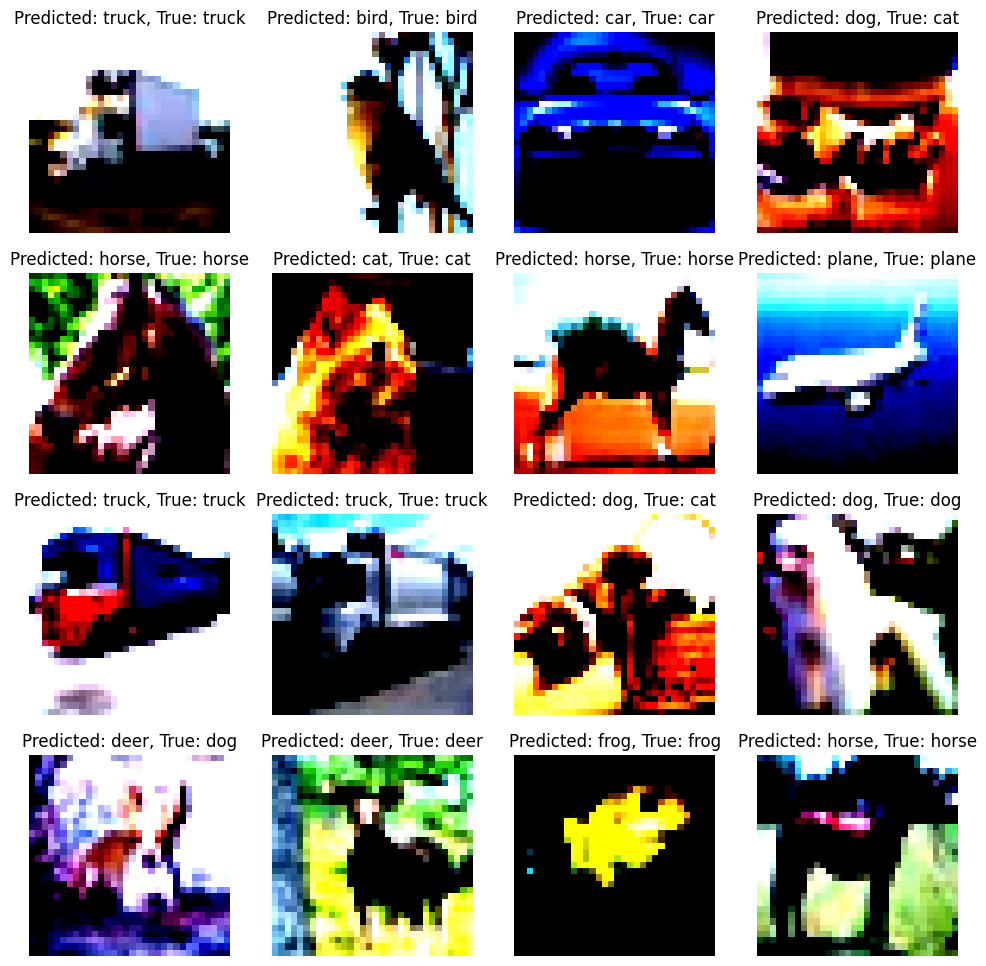

In [50]:

h=4
w=4
fig, axs = plt.subplots(h, w, figsize=(12, 12))

for i in range(0,h):
    for j in range(0,w):
        plot_image(testset, model_ft, classes, axs[i,j])
plt.show()

# Feature extraction

In [51]:
# Import ResNet50 model pretrained on ImageNet
model_fe = models.resnet50(pretrained=True)

for param in model_fe.parameters(): # по этим параметрам не будут браться градиенты, "заморозили" веса
    param.requires_grad = False
#Modify conv1 to suit CIFAR-10
model_fe.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer according to the number of classes
num_features = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fe = model_fe.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_fe.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)



In [52]:
model_fe, train_losses_fe, train_accuracies_fe, test_losses_fe, test_accuracies_fe = train_epochs(
  model_fe, trainloader, testloader, criterion, optimizer, device,
  num_epochs)

Epoch 1/30
Train Loss: 2.8071 - Train Accuracy: 26.15%
Test Loss: 2.8763 - Test Accuracy: 28.29%

Epoch 2/30
Train Loss: 2.8111 - Train Accuracy: 28.15%
Test Loss: 3.0881 - Test Accuracy: 27.46%

Epoch 3/30
Train Loss: 2.8561 - Train Accuracy: 28.28%
Test Loss: 2.5490 - Test Accuracy: 34.24%

Epoch 4/30
Train Loss: 2.8743 - Train Accuracy: 28.64%
Test Loss: 2.7774 - Test Accuracy: 31.28%

Epoch 5/30
Train Loss: 2.8481 - Train Accuracy: 28.93%
Test Loss: 2.9220 - Test Accuracy: 31.43%

Epoch 6/30
Train Loss: 2.8274 - Train Accuracy: 29.28%
Test Loss: 2.6554 - Test Accuracy: 33.54%

Epoch 7/30
Train Loss: 2.8257 - Train Accuracy: 29.75%
Test Loss: 2.6605 - Test Accuracy: 33.26%

Epoch 8/30
Train Loss: 2.8829 - Train Accuracy: 28.93%
Test Loss: 2.8498 - Test Accuracy: 32.82%

Epoch 9/30
Train Loss: 2.7916 - Train Accuracy: 29.57%
Test Loss: 2.5884 - Test Accuracy: 33.66%

Epoch 10/30
Train Loss: 2.7950 - Train Accuracy: 29.25%
Test Loss: 2.5156 - Test Accuracy: 34.23%

Epoch 11/30
Train L

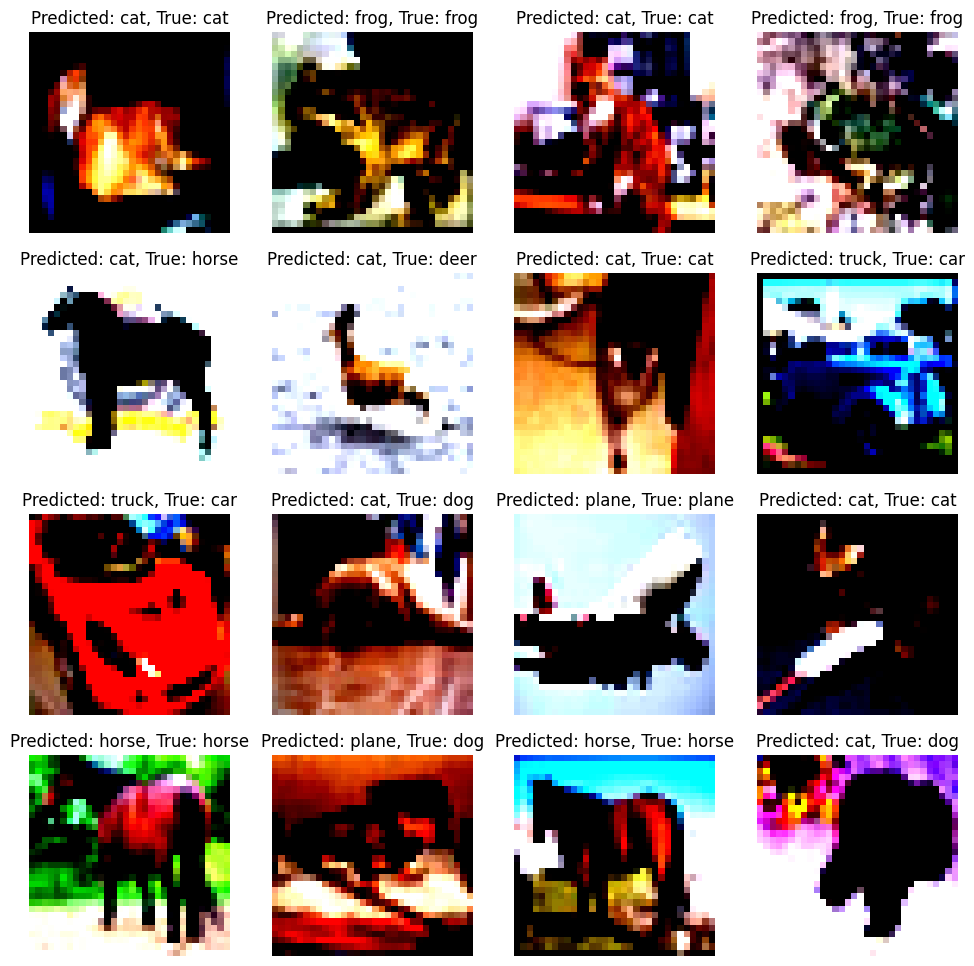

In [53]:
h=4
w=4
fig, axs = plt.subplots(h, w, figsize=(12, 12))

for i in range(0,h):
    for j in range(0,w):
        plot_image(testset, model_fe, classes, axs[i,j])
plt.show()

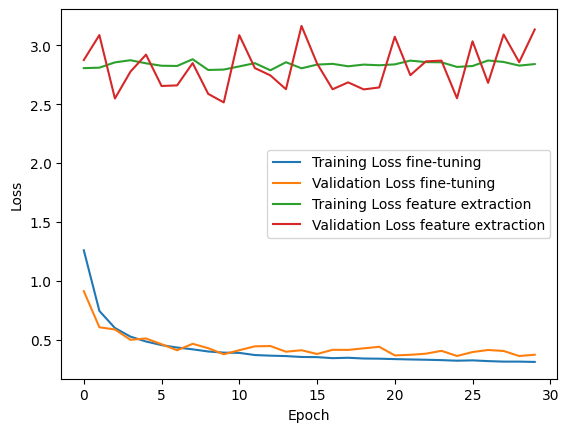

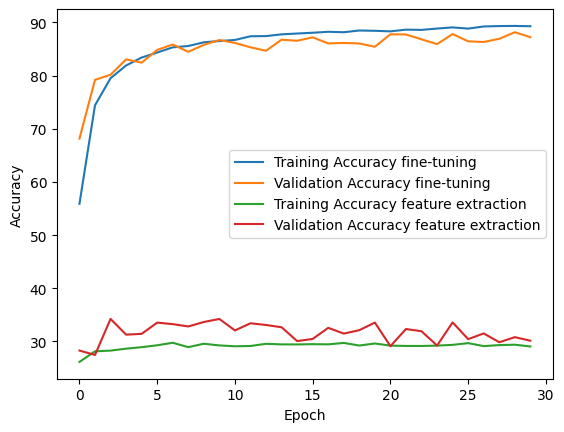

In [54]:
plot_loss(train_losses_ft, test_losses_ft, ' fine-tuning')
plot_loss(train_losses_fe, test_losses_fe, ' feature extraction')
plt.legend()
plt.show()
plot_accuracy(train_accuracies_ft, test_accuracies_ft, ' fine-tuning')
plot_accuracy(train_accuracies_fe, test_accuracies_fe, ' feature extraction')
plt.legend()
plt.show()